Email spam detection bot using Tensorflow

Import necessary modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

Reading the dataset

In [2]:
data=pd.read_csv('emails.csv')
data.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [4]:
data.shape

(5728, 2)

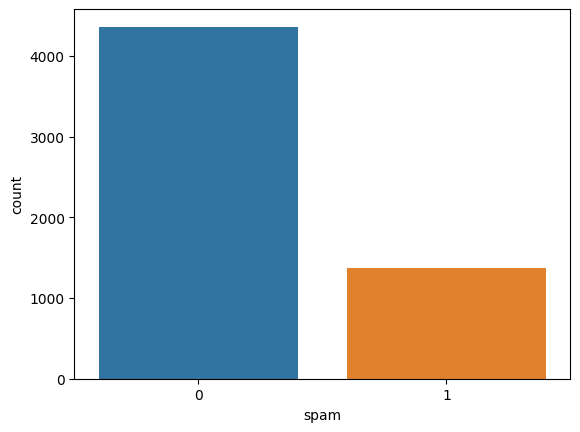

In [5]:
sns.countplot(x="spam",data=data)
plt.show()

We can clearly see that the number of spam samples is much lesser than the number of ham samples. This indicates that the dataset is unbalanced.

We will now attempt to balance the dataset.

Text(0.5, 0, 'Message types')

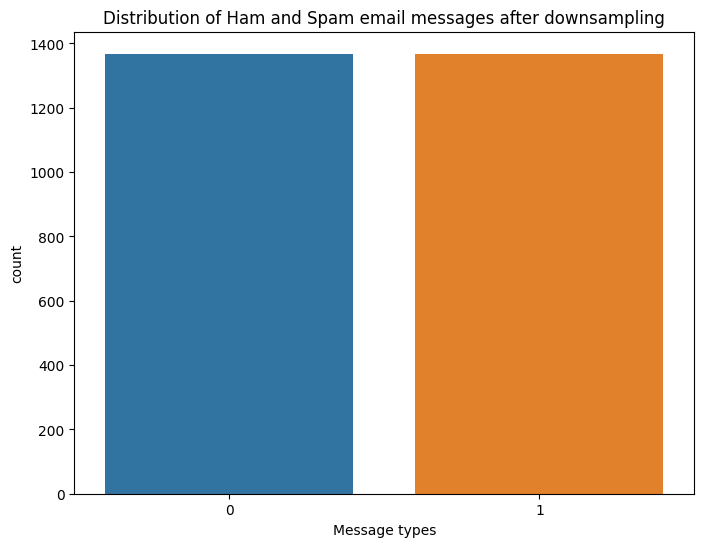

In [16]:
# Downsampling to balance the dataset
ham_msg = data[data.spam == 0]
spam_msg = data[data.spam == 1]
ham_msg = ham_msg.sample(n=len(spam_msg),random_state=42)

# Plotting the counts of down sampled dataset


balanced_data = pd.concat([ham_msg,spam_msg])
plt.figure(figsize=(8, 6))
sns.countplot(data = balanced_data, x='spam')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')

Text Preprocessing

In this section we will perform the following tasks on the text data

-Stopword Removal

-Punctuation Removal

-Stemming or Lemmatization

In [17]:
balanced_data['text']=balanced_data['text'].str.replace('Subject','')
balanced_data.head()

,text,spam
1547,: interview schedule for jinbaek kim i didn '...,0
2730,": re : wednesday meeting eric , i think we c...",0
4843,: re : london research group i ' d do it as s...,0
2856,": re : congratulations vince , thanks for you...",0
3804,: osman sezgen steve kromer is requesting tha...,0


In [18]:
punctuations_list=string.punctuation
def remove_punctuation(text):
    temp=str.maketrans('','',punctuations_list)
    return text.translate(temp)

balanced_data['text']=balanced_data['text'].apply(lambda x: remove_punctuation(x))
balanced_data.head()

,text,spam
1547,interview schedule for jinbaek kim i didn t...,0
2730,re wednesday meeting eric i think we can ...,0
4843,re london research group i d do it as soon...,0
2856,re congratulations vince thanks for your n...,0
3804,osman sezgen steve kromer is requesting that...,0


In [19]:
def remove_stopword(text):
    stop_words=stopwords.words('english')

    imp_words=[]

    # storing the important words
    for word in str(text).split():
        word=word.lower()

        if word not in stop_words:
            imp_words.append(word)
        
    output=" ".join(imp_words)

    return output

balanced_data['text']=balanced_data['text'].apply(lambda text: remove_stopword(text))
balanced_data.head()

,text,spam
1547,interview schedule jinbaek kim see went happy ...,0
2730,wednesday meeting eric think skip meeting disc...,0
4843,london research group soon possible call exact...,0
2856,congratulations vince thanks note congratulati...,0
3804,osman sezgen steve kromer requesting osman spe...,0


We will now plot a word cloud. A word cloud is a text visualization tool that helps us to get insights into the most frequent words present in the corpus of the data.

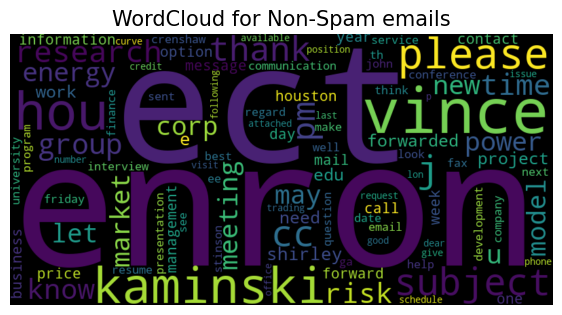

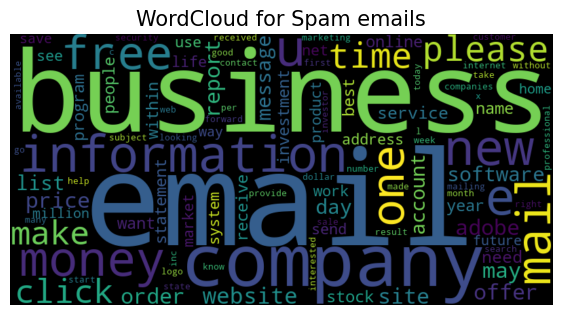

In [20]:
def plot_word_cloud(data, typ):
	email_corpus = " ".join(data['text'])

	plt.figure(figsize=(7, 7))

	wc = WordCloud(background_color='black',
				max_words=100,
				width=800,
				height=400,
				collocations=False).generate(email_corpus)

	plt.imshow(wc, interpolation='bilinear')
	plt.title(f'WordCloud for {typ} emails', fontsize=15)
	plt.axis('off')
	plt.show()

plot_word_cloud(balanced_data[balanced_data['spam'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['spam'] == 1], typ='Spam')

Word to vector conversion

We convert our words into vectors with the token ID's. We do this since machine learning models cannot be fed text data.

In [21]:
#train test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],
													balanced_data['spam'],
													test_size = 0.2,
													random_state = 42)


We have fitted the tokenizer on our training data. We will use it to convert the training and validation data both to vectors.

In [22]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
max_len = 100 # maximum sequence length
train_sequences = pad_sequences(train_sequences,
								maxlen=max_len,
								padding='post',
								truncating='post')
test_sequences = pad_sequences(test_sequences,
							maxlen=max_len,
							padding='post',
							truncating='post')